## Intro to convolutional networks

In [1]:
''' Make convolutional layers for feature extraction '''

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [2]:
''' Add dense layers for classification '''

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [3]:
''' Compiling and training '''

from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = \
    mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 70s 1ms/step - loss: 0.1870 - acc: 0.9411
Epoch 2/5
60000/60000 [==============================] - 72s 1ms/step - loss: 0.0511 - acc: 0.9844
Epoch 3/5
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0357 - acc: 0.9887
Epoch 4/5
60000/60000 [==============================] - 72s 1ms/step - loss: 0.0271 - acc: 0.9919
Epoch 5/5
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0208 - acc: 0.9935


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

### Properties of convolution operation

The key characteristics of convnets:

1) **The patterns they learn are translation invariant.** That's why they are efficient when processing images (because *the visual world is fundamentally translation invariant*).

2) **They can learn spatial hierarchies of patterns.** They can learn increasingly complex and abstract visual concepts (because *the visual world is fundamentally spatially hierarchical*).

Operate over 3D tensors, called feature maps, with two spatial axes (*height* and *width*) as well as a *depth* axis. For an RGB image the dimension of the depth axis is 3 (red, blue and green channels). Output - 3D tensor, has a heigth and width, depth is arbitrary. Output depth is parameter of the layer, stands not for colors, but for *filters*.

In the MNIST, the first Conv2D layer takes (28, 28, 1) and outputs (26, 26, 32) for 32 filters. 

Convolutions are defined by two key parameters:

* *Size of the pathes extracted from the inputs* - typically 3\*3 or 5\*5.

* *Depth of the output feature map* - the number of filters computed (32, 64, etc.)

Convolution works by *sliding* these windows over the 3D input feature map, producing 3D patch of features (shape (window_heigth, window_width, input_depth)). Each 3D patch is transformed (by dot prodict with *convolution kernel*) into a 1D vector of shape (output_depth,). All these vectors are then spatially reassembled into a 3D output map of shape (height, width, output_depth). 

Output width and height may differ from those of input because of two reasons:

* Border effects - countered by padding.

* The use of strides.

#### *Border effects and padding*

If you feel, that border effects are extremely needed, for a 3\*3 patch add one row and one column to the each border. For a 5\*5 patch add two rows. Argument: *padding*=['valid', 'same'], where 'valid' stands for 'no padding' and 'same' means 'make output the same height and width as input'.

#### *Convolution strides*

You can not slide your window over all image one pixel by one, but rather pitch specific locations for window. E.g. using stride 2 means the width and height of the feature map are downsampled by factor of 2. Usually not used

### The max-pooling operation

Each size of the feature maps is halved after every MaxPooling2D layer (see example).

Max pooling - max tensor operation over local pathces. The size of tensor is the parameter of the layer. In the example - it's extracting max in the windows of (2, 2) with stride 2.

When we delete max-pooling, two things happen:

1) The model isn't conducive to learning a spatial hierarchy of features because next layer learns over smaller windows of the initial image.

2) The final feature map is very huge.

You can use AveragePooling2D instead, or some other pooling layer, or use strides in the prior convolution layer. But usually MaxPooling is the right choice.

## Training a convnet from scratch on a small dataset

In [3]:
''' Dogs vs cats dataset '''

# www.kaggle.com/c/dogs-vs-cats/data

import os, shutil

original_dataset_dir = '/Users/A.Miroshnikova/Documents/Datasets/kaggle_original/dogs_vs_cats/train'

base_dir = '/Users/A.Miroshnikova/Documents/Datasets/cats_vs_dogs_small'
os.mkdir(base_dir)

# Make directories for sets
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Make directories for cats and dogs
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

FileExistsError: [Errno 17] File exists: '/Users/A.Miroshnikova/Documents/Datasets/cats_vs_dogs_small'

In [5]:
# Copy the images
# Cats train
fnames = ['cat.{}.jpg'.format(i) for i in range(2000, 3000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Cats validation
fnames = ['cat.{}.jpg'.format(i) for i in range(3000, 3500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Cats test
fnames = ['cat.{}.jpg'.format(i) for i in range(3500, 4000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Dogs train
fnames = ['dog.{}.jpg'.format(i) for i in range(2000, 3000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Dogs validation
fnames = ['dog.{}.jpg'.format(i) for i in range(3000, 3500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Dogs test
fnames = ['dog.{}.jpg'.format(i) for i in range(3500, 4000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [6]:
# Check files

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total validation cat images: 500
total test cat images: 500
total training dog images: 1000
total validation dog images: 500
total test dog images: 500


#### *Small convnet*

We add one more layer comparing to MNIST and make classification Dense layer also bigger.

In [7]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(150, 150, 3))) # preprocessing will make all images 150*150
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### *Data preprocessing*

1) Read the picture files.

2) Decode the JPEG content to RGB grid of pixels.

3) Convert these into floating-point tensors.

4) Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### *Fitting the model*

In [17]:
# With total of 2000 images, 20 images per batch, we need 2000/20=100 steps
#  for generator to go over all training images.
# For validation dataset - with 1000 images and batch size of 20 we need 1000/20=50 steps
#  for generator to go over all validation images.

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 132s 1s/step - loss: 0.6891 - acc: 0.5245 - val_loss: 0.6681 - val_acc: 0.6210
Epoch 2/30
100/100 [==============================] - 133s 1s/step - loss: 0.6560 - acc: 0.6080 - val_loss: 0.6298 - val_acc: 0.6430
Epoch 3/30
100/100 [==============================] - 132s 1s/step - loss: 0.6195 - acc: 0.6595 - val_loss: 0.5951 - val_acc: 0.6940
Epoch 4/30
100/100 [==============================] - 127s 1s/step - loss: 0.5920 - acc: 0.6935 - val_loss: 0.6423 - val_acc: 0.6350
Epoch 5/30
100/100 [==============================] - 125s 1s/step - loss: 0.5614 - acc: 0.7075 - val_loss: 0.6569 - val_acc: 0.6260
Epoch 6/30
100/100 [==============================] - 131s 1s/step - loss: 0.5370 - acc: 0.7165 - val_loss: 0.5706 - val_acc: 0.7040
Epoch 7/30
100/100 [==============================] - 129s 1s/step - loss: 0.5072 - acc: 0.7435 - val_loss: 0.5293 - val_acc: 0.7330
Epoch 8/30
100/100 [==============================] - 128s 1s/step - 

In [18]:
model.save('cats_and_dogs_small_1.h5')

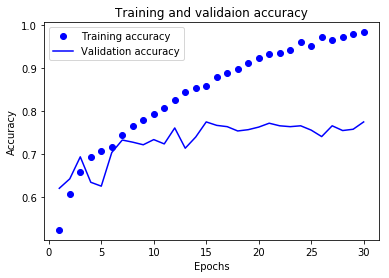

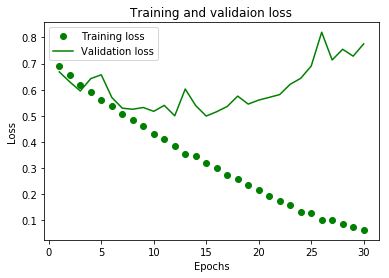

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validaion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validaion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()